In [1]:
import dinkum
from dinkum.vfg import Gene, Receptor, Ligand
from dinkum.vfn import Tissue

In [2]:
dinkum.reset()

initializing: dinkum v0.3.1


In [3]:
# define a Gene with name 'X', assign it to variable 'x' in Python
x = Gene(name='X')

In [4]:
# define another Gene with name 'Y', assign it to variable 'y' in Python
y = Gene(name='Y')

In [5]:
# create a Tissue, and add genes to it.
m = Tissue(name='M')

start=1 stop=5


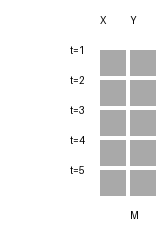

In [6]:
# run for 5 ticks (1 to 5)
dinkum.run_and_display(stop=5)

Underwhelming, ehh? All the genes are off because ... we haven't turned any genes on!

In [7]:
# turn 'x' on in tissue m starting at time t
x.is_present(where=m, start=1)

start=1 stop=5


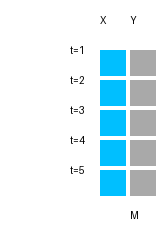

In [8]:
# run for 5 ticks (1 to 5)
dinkum.run_and_display(stop=5)

Better, but still underwhelming - we haven't defined any regulatory relationships! Let's make X a maternal effect gene by turning it on at time t=1, and then have it positively regulate Y.

initializing: dinkum v0.3.1
start=1 stop=5


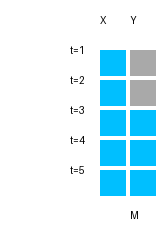

In [9]:
dinkum.reset()

x = Gene(name='X')
y = Gene(name='Y')
m = Tissue(name='M')

x.is_present(where=m, start=1)

# now define a regulatory relationship!
y.activated_by(source=x, delay=2)

# run for 5 ticks (1 to 5)
dinkum.run_and_display(stop=5)

Here you can see that Y is activated by X after a delay of 2!

So this is kind of the minimum you need for something interesting: you need to two genes; a tissue; a transcriptionally active gene; and a regulatory relationship with the other gene.

What kind of regulatory interactions are possible?

## Cell-autonomous interactions

There are many possible gene-gene interactions *within* a cell.

We've already seen two - `is_present(where=tissue, start=None, duration=None)` and `activated_by(source, delay=1)`.

Here's their description:

* `is_present(where=tissue, start=None, duration=None)` - this gene is constitutively "on" from tick `start` for duration `duration`.
* `activated_by(source, delay=1)` - `source` is an upstream activator that acts at the given delay (in ticks).

Here are the remaining cell autonomous gene interactions that we have implemented:

* `activated_or(sources=[...], delay=1)` - `sources` is a list of upstream activators, any one of which suffices to activate this gene.
* `and_not(activator=..., repressor=..., delay=1)` - `activator` activates unless `repressor` is active.
* `activated_by_and(sources=[...], delay=1)` - `sources` is a list of upstream activators, all of which must be present to activate this gene.
* `toggle_repressed(tf=..., cofactor=..., delay=1)` - this gene is repressed if `tf` is absent, or if `tf` is present without `cofactor`; it is active if both`tf` and `cofactor` are present.

## Side note: introducing multiple regulatory influences via lists

`activated_or` and `activated_by_and` both take *lists* of genes, as opposed to a single gene; to make a Python list, you enclose the genes in square brackets and separate them with commas, e.g. `[x, y]`. The notation is used as below for `z`:

initializing: dinkum v0.3.1
start=1 stop=7


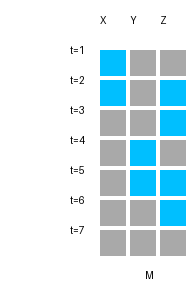

In [10]:
dinkum.reset()

x = Gene(name='X')
y = Gene(name='Y')
z = Gene(name='Z')
m = Tissue(name='M')

x.is_present(where=m, start=1, duration=2)
y.is_present(where=m, start=4, duration=2)

z.activated_or(sources=[x, y])

# run for 7 ticks
dinkum.run_and_display(stop=7)

## Non-cell-autonomous regulation: interactions across cells/tissues

dinkum provides the concept of "tissues", which are simply a collection of cells that have the same regulatory state.

With multiple tissues, you need to define their neighborhood relationship - who is next to whom? - and, if you want them to cross-regulate, you need to define signaling factors and receptors.

dinkum supports basic _ligands_ (signaling molecules) and _receptors_. In the dinkum model, ligands are genes that are transcribed (and so they must be transcriptionally activated in a tissue), and then they turn on corresponding receptors in neighboring tissues that are inherently transcriptional activators. The receptor also must be transcribed, but is does not activate downstream genes until the ligand is present.


initializing: dinkum v0.3.1
start=1 stop=10


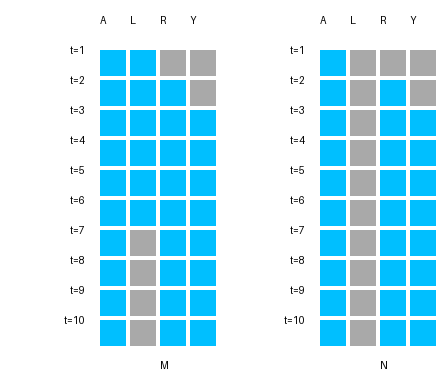

In [11]:
dinkum.reset()

# create two tissues                                                               
m = Tissue(name='M')
n = Tissue(name='N')

# make them neighbors.                                                          
m.add_neighbor(neighbor=n)
n.add_neighbor(neighbor=m)

a = Gene(name='A')          # permanent positive input in M and N; will turn on receptor R                                                                             
m.add_gene(gene=a, start=1)
n.add_gene(gene=a, start=1)

# VFG:                                                                      
l = Ligand(name='L')                       # ligand                                   
r = Receptor(name='R', ligand=l)           # receptor with associated ligand                                  
y = Gene(name='Y')                         # output         

# ligand L: on in tissue M
l.is_present(where=m, start=1, duration=6)

# receptor R: transcribed by A, activated by ligand L.
r.activated_by(source=a)

# gene Y turned on by receptor R
y.activated_by(source=r)    # transcription of Y turned on by activated R.  

dinkum.run_and_display(stop=10)

## An intentional limitation of dinkum: only one regulatory rule is allowed per gene

The following model fails; why?

In [12]:
dinkum.reset()

x = Gene(name='X')
y = Gene(name='Y')
m = Tissue(name='M')

y.is_present(where=m, start=1)
y.activated_by(source=x, delay=2)

dinkum.run_and_display(stop=10)

initializing: dinkum v0.3.1
start=1 stop=10


ERROR: multiple rules containing Y
Halting execution.


The problem here is that we're defining two distinct regulatory interactions for `Y` - it's both always present in tissue `M`, and turned on by `X`. That's not allowed, because dinkum wouldn't know how to combine the two interactions. So the rule that dinkum enforces is that there has to be one, and only one, regulatory rule defined for each gene.